In [ ]:
!pip install ipympl
!pip install trimesh
!python -m pip install scipy

In [1]:
%matplotlib ipympl
import numpy as np
import scipy.spatial as sp
import trimesh
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing
workers = multiprocessing.cpu_count()
np.set_printoptions(linewidth=100)

In [2]:
num_of_frames = 30

point_clouds = []
# Carregando todas as point clouds
for index in range(0, num_of_frames):
    # Usando operador ternario para avaliar se é necessário o 0 a mais
    file_name = "./KITTI-Sequence/0000"+ (("0" + str(index)) if index < 10 else str(index) )+"_points.obj"
    point_cloud = trimesh.load(file_name).vertices
    point_clouds.append(point_cloud)

/tmp/ipykernel_311997/3622941748.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, zdir='z', s=0.3, c=color)
/tmp/ipykernel_311997/3622941748.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


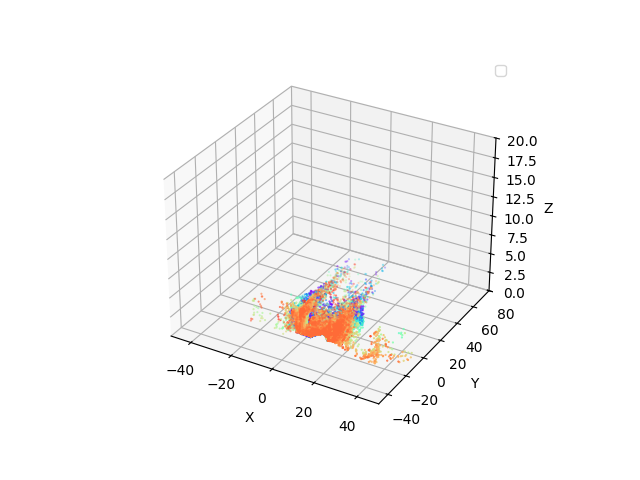

In [3]:
ax = plt.figure().add_subplot(projection='3d')
pts_to_show = list([point_clouds[n] for n in range(num_of_frames)])
#pts_to_show = list([point_clouds[n] for n in [0, 1]])
colors = cm.rainbow(np.linspace(0, 1, len(pts_to_show)))
for color, point_cloud in zip(colors, pts_to_show):
    size = len(point_cloud.T[0])
    choices = np.random.choice(size, size=1000, replace=False)
    x = point_cloud.T[0][choices]
    y = point_cloud.T[1][choices]
    z = point_cloud.T[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.3, c=color)

ax.legend()
#ax.plot(*pos_to_plot_truth, c='magenta')
#ax.plot(*pos_to_plot, c='orange')

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [9]:
def icp(source_points, target_points, epsilon = 1e-3, leafsize = 30, balanced_tree=False):

    def register_points(a, b):
        a1 = np.column_stack((a,np.ones(a.shape[0])))
        b1 = np.column_stack((b,np.ones(b.shape[0])))

        matrixA = np.tensordot(a1,a1.T,axes=[0,1])
        matrixR = np.tensordot(a1,b1.T,axes=[0,1])
        matrixAinv = np.linalg.inv(matrixA)
        
        return np.tensordot(matrixAinv,matrixR,axes=1).transpose() 

    # Keeping original points untouched

    source_copy = source_points.copy()
    source_copy = np.column_stack((source_copy,np.ones(source_copy.shape[0])))
    target_copy = target_points.copy()
    target_copy = np.column_stack((target_copy,np.ones(target_copy.shape[0])))
    
    current_points = source_points.copy()
    last_rmse = 0

    while True:
        # Input has to be of shape (N, M) where
        # N = Number of points
        # M = dimensions
        # Thus the transpose is used
        kdt = sp.KDTree(target_points, leafsize = leafsize, balanced_tree=balanced_tree, copy_data=False)
        _, indexes = kdt.query(current_points, k = 1, workers = workers)
        #print(indexes.shape, target_points.shape, current_points.shape)
        # Getting position of queried points
        target_selected = target_points[indexes, :]
        print(target_selected, indexes)
        # Calculating transformation Matrix
        transformation_matrix = register_points(source_points, target_selected)

        # Updating current points
        predicted_points = np.dot(transformation_matrix, source_copy.T)

        # Calculating RMSE
        #print(predicted_points.T.shape, target_selected.shape)
        rmse = np.sqrt(np.mean(np.sum((predicted_points.T[:, :3] - target_selected[:, :3]) ** 2, axis=None)))

        if np.abs(rmse - last_rmse) < epsilon:
            return transformation_matrix, rmse
        
        current_points = predicted_points[:3, :].T
        last_rmse = rmse
        
        

[[-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 ...
 [ 1.448161  3.846375 -1.778548]
 [ 1.426188  3.824943 -1.765563]
 [ 1.493227  4.112738 -1.749579]] [    0     0     0 ... 62336 62337 60272]
[[-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 ...
 [ 1.414232  3.863128 -1.780585]
 [ 1.414232  3.863128 -1.780585]
 [ 1.493227  4.112738 -1.749579]] [    0     0     0 ... 62339 62339 60272]
[[-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 ...
 [ 1.414232  3.863128 -1.780585]
 [ 1.414232  3.863128 -1.780585]
 [ 1.493227  4.112738 -1.749579]] [    0     0     0 ... 62339 62339 60272]
[[-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 [-9.056182 17.949978  0.888338]
 ...
 [ 1.429238  3.922909 -1.765588]
 [ 1.414232  3.863128 -1.780585]
 [ 1.493227  4.112738 -1.749579]] [    0     0     0 ... 61658 62339 60272]
[[-9.056182 17.9

In [ ]:
t_matrices = []
aligned_pc = []
aligned_pc.append(np.column_stack((point_clouds[0],np.ones(point_clouds[0].shape[0]))))
for i in range(num_of_frames - 1):
    tm, rmse = icp(point_clouds[i], point_clouds[i+1])
    p = np.column_stack((point_clouds[i+1],np.ones(point_clouds[i+1].shape[0])))
    print(tm)
    p = np.array([tm @ q.T for q in p])
    print(p[0], "\n=============")
    #print(p, "\n=========================\n")
    aligned_pc.append(p)
    t_matrices.append(tm)

In [ ]:
frame1 = 0
frame2 = 1

tm, _ = icp(point_clouds[frame1], point_clouds[frame2])
print(tm)

ax = plt.figure().add_subplot(projection='3d')

size = len(point_clouds[frame1])
choices = np.random.choice(size, size=20000, replace=False)
x = point_clouds[frame1].T[0][choices]
y = point_clouds[frame1].T[1][choices]
z = point_clouds[frame1].T[2][choices]
ax.scatter(x, y, z, zdir='z', s=0.3, c='red')

p = np.append(point_clouds[frame2], [[1]] * point_clouds[frame2].shape[0], axis = 1)
print(p)
p = np.array([tm @ q for q in p]).T
#p = p.T
print(p.T)

size = len(point_clouds[frame2])
choices = np.random.choice(size, size=20000, replace=False)

x = p[0][choices]
y = p[1][choices]
z = p[2][choices]
ax.scatter(x, y, z, zdir='z', s=0.1, c='blue')
#ax.plot(*pos_to_plot_truth, c='blue')
#ax.plot(*pos_to_plot, c='orange')

ax.legend()

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
real_position = np.eye(4,4)
groun_truth_transformation_matrix = np.load("./ground_truth.npy")
ground_truth_positions = []

lidar_position = np.eye(4,4)
positions = []

positions.append(lidar_position)
for tm, gt in zip(t_matrices, groun_truth_transformation_matrix):
    real_position = gt @ real_position
    ground_truth_positions.append(real_position)
    
    lidar_position = tm @ lidar_position
    positions.append(lidar_position)

positions = np.array(positions)
ground_truth_positions = np.array(ground_truth_positions)
#print(positions)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos_to_plot = positions[:,:3,3].T
ax.plot(*pos_to_plot)
#ax.plot(*positions[:,:3,3])
ax.legend()
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos_to_plot_truth = ground_truth_positions[:,:3,3].T
ax.plot(*pos_to_plot_truth, c='blue')
ax.plot(*pos_to_plot, c='red')
ax.legend()
ax.set_xlim(-2.5, 0.5)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 30)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
#pts_to_show = list([aligned_pc[n] for n in range(len(aligned_pc))])
pts_to_show = list([point_clouds[n] for n in [0, 1]])
colors = cm.rainbow(np.linspace(0, 1, len(pts_to_show)))
for color, apc in zip(colors, pts_to_show):
    size = len(apc.T[0])
    choices = np.random.choice(size, size=50000, replace=False)
    x = apc.T[0][choices]
    y = apc.T[1][choices]
    z = apc.T[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.1, c=color)

ax.legend()
ax.plot(*pos_to_plot_truth, c='magenta')
ax.plot(*pos_to_plot, c='orange')

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()